# Notebook description
Notebook showing the results of the model for the Nº of drops variable using the standarization procedure on the X variables for comparison with the results from the notebook *N_of_drops_model*.

# Loading the libraries and Preprocessing
## Import libraries
Load the libraries necessary to do data preparation and for machine learning.


In [215]:
# EDA and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import itertools

# The Patch library is imported to fix a legend issue, not allowing to show more than one variable
from matplotlib.patches import Patch

# Library to format the axes
import matplotlib.ticker as mtick

# Plots appear in the same notebook cell
%matplotlib inline

# Seaborn style
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.set_context("paper")

# Activate latex text rendering for figure labels
from matplotlib import rc
rc('text', usetex=False)

# Models from Scikit-Learn
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor

# Preprocessing and feature selection
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle

# Model Evaluations
from sklearn.model_selection import train_test_split, cross_val_score, KFold, cross_validate
from sklearn.metrics import mean_squared_error

# Tree interpreter
from treeinterpreter import treeinterpreter as ti

# Shap library to explain models intuitively
import shap
shap.initjs() # Activate Javascript option for Jupyter notebooks

# Function to display dataframes side_by_side
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

# Ignore warning
import warnings
warnings.filterwarnings("ignore")

## Load data
We will load the *data_final.csv* file with the preprocessed data.

In [216]:
# Load dataset
data_final = pd.read_csv("data_final.csv")
data_final.shape

(231, 8)

## Check the dataset
We will check the head and tail of the dataset to confirm it has been loaded correctly.

In [217]:
data_final.head()

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),nº of drops,Total Volume Deposited (ul),Amine (%)
0,135.0,26.0,185.0,175,75.0,1904.761905,0.352381,1.14
1,110.0,23.0,190.0,200,50.0,2500.000000,0.475000,1.14
2,135.0,26.0,190.0,175,50.0,2857.142857,0.542857,1.14
3,145.0,27.0,220.0,100,100.0,2500.000000,0.550000,1.14
4,130.0,26.0,219.0,95,95.0,2770.083102,0.606648,1.14


In [218]:
data_final.tail()

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),nº of drops,Total Volume Deposited (ul),Amine (%)
226,155.000000,26.000000,225.0,50,80.0,6250.0,1.40625,2.00
227,155.000000,26.000000,225.0,50,80.0,6250.0,1.40625,2.00
228,155.000000,26.000000,225.0,50,80.0,6250.0,1.40625,2.00
229,153.500000,25.500000,238.0,50,80.0,6250.0,1.48750,2.00
230,149.873239,25.507042,180.0,50,50.0,10000.0,1.80000,1.14


## Prediction of the variable **Nº of drops**
We will build a machine learning model to predict the **Nº of drops** deposited by considering all the dataset variables with the exception of the **Total Volume Deposited** that will be dropped from the dataset.

### Select model variables
We will select the variables used in the model, shuffle the data, and split the dataset into X and y.

In [219]:
# Drop columns
data_NOD = data_final.drop(labels=['Total Volume Deposited (ul)'], axis=1, inplace=False)

# Check the dataset
data_NOD

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),nº of drops,Amine (%)
0,135.000000,26.000000,185.0,175,75.0,1904.761905,1.14
1,110.000000,23.000000,190.0,200,50.0,2500.000000,1.14
2,135.000000,26.000000,190.0,175,50.0,2857.142857,1.14
3,145.000000,27.000000,220.0,100,100.0,2500.000000,1.14
4,130.000000,26.000000,219.0,95,95.0,2770.083102,1.14
...,...,...,...,...,...,...,...
226,155.000000,26.000000,225.0,50,80.0,6250.000000,2.00
227,155.000000,26.000000,225.0,50,80.0,6250.000000,2.00
228,155.000000,26.000000,225.0,50,80.0,6250.000000,2.00
229,153.500000,25.500000,238.0,50,80.0,6250.000000,2.00


In [220]:
# Shuffle the data
data_NOD = shuffle(data_NOD, random_state = 42) # A random state was set to keep the results reproducible

data_NOD.reset_index(inplace = True, drop = True)

We shuffle the data to ensure there is no influence on how the data has been introduced in the dataset on the model results.

In [221]:
# Split the data set into X and y
X_NOD = data_NOD.drop(labels=['nº of drops'], axis=1)
y_NOD = data_NOD['nº of drops']

### Train/test splitting
We split the data into train and test datasets by using the ratio 80:20. 

In [222]:
# Split the training data into training and test sets (80:20)
X_train_NOD, X_test_NOD, y_train_NOD, y_test_NOD = train_test_split(X_NOD,
                                                  y_NOD,
                                                  test_size=0.2, random_state = 42)

In [223]:
# Standarize the X variables
np.random.seed(42)
sc = StandardScaler()
X_train_NOD = pd.DataFrame(sc.fit_transform(X_train_NOD), columns = ['Average Voltage (V)', 
                                        'Average Pulse Length (us)', 'Average Drop Volume (pl)', 
                                        'Drop Pitch (um)', 'Line Pitch (um)', 'Amine (%)'])
X_test_NOD = pd.DataFrame(sc.transform(X_test_NOD), columns = ['Average Voltage (V)', 
                                        'Average Pulse Length (us)', 'Average Drop Volume (pl)', 
                                        'Drop Pitch (um)', 'Line Pitch (um)', 'Amine (%)'])

# Check the range of values from all columns
X_train_NOD.describe()

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),Amine (%)
count,1.840000e+02,1.840000e+02,1.840000e+02,1.840000e+02,1.840000e+02,1.840000e+02
mean,-4.223675e-17,-4.402276e-15,2.461799e-16,4.344351e-17,4.344351e-17,-3.427210e-16
std,1.002729e+00,1.002729e+00,1.002729e+00,1.002729e+00,1.002729e+00,1.002729e+00
min,-2.480126e+00,-5.417823e+00,-3.270076e+00,-8.940108e-01,-1.839213e+00,-3.977705e+00
25%,-6.417679e-01,-5.554976e-01,-6.885847e-01,-8.132161e-01,-1.065825e+00,-1.233449e+00
50%,-1.687775e-02,-6.241671e-02,8.586264e-02,-3.284480e-01,4.809506e-01,8.367780e-01
75%,2.101541e-01,4.169675e-01,8.603100e-01,9.642670e-01,6.742976e-01,8.367780e-01
max,3.752356e+00,4.306828e+00,1.892906e+00,2.418571e+00,1.254339e+00,1.558950e+00


In [224]:
# Check the range of values from all columns
X_test_NOD.describe()

,Average Voltage (V),Average Pulse Length (us),Average Drop Volume (pl),Drop Pitch (um),Line Pitch (um),Amine (%)
count,47.000000,47.000000,47.000000,47.000000,47.000000,47.000000
mean,-0.096920,-0.306772,-0.019594,0.118501,-0.169024,0.037779
std,0.928998,1.237137,1.012848,1.048688,1.055489,0.963297
min,-2.480126,-5.417823,-1.979330,-0.894011,-1.839213,-1.233449
25%,-0.574511,-0.555498,-0.766029,-0.813216,-1.259172,-1.233449
50%,-0.014036,-0.069265,-0.043212,-0.247653,0.287604,0.836778
75%,0.322249,0.416967,0.860310,0.964267,0.674298,0.836778
max,3.707518,1.389433,1.634757,2.337777,1.641032,1.558950


In [225]:
# Check the range of values from all columns
y_train_NOD.describe()

count      184.000000
mean      4976.595225
std       1224.097682
min       1904.761905
25%       3906.250000
50%       5000.000000
75%       5882.352941
max      10000.000000
Name: nº of drops, dtype: float64

In [226]:
# Check the range of values from all columns
y_test_NOD.describe()

count      47.000000
mean     5044.874953
std      1219.078954
min      3246.753247
25%      3906.250000
50%      5000.000000
75%      6250.000000
max      7407.407407
Name: nº of drops, dtype: float64

### Build baseline models
We will build the baseline models to select the best one for optimization of hyperparameters. Some of the code has been adapted from: https://github.com/mrdbourke.

In [227]:
# Put models in a dictionary
models = {
          'Linear Regression': LinearRegression(),
          'Random Forest': RandomForestRegressor(),
          'AdaBoost Regressor': AdaBoostRegressor(),
          'Gradient Boosting': GradientBoostingRegressor()
         }

# Create a function to fit and score models
def fit_and_score(models, X_train, y_train):
    """
    Fits and evaluates given machine learning models.
    models : a dict of different Scikit-Learn machine learning models
    X_train : training data (no labels)
    X_test : testing data (no labels)
    y_train : training labels
    y_test : test labels
    """
    
    # Set random seed
    np.random.seed(42)
    
    # Make a dictionary to keep model scores
    model_validation_scores = {}

    # Instantiate K-Fold cross validation
    cv = KFold(n_splits = 5) # n_splits = 5 means 80:20 training:validation
    
    # Loop through models
    for name, model in models.items():
        # Fit the model to the data
        model.fit(X_train, y_train)
        
        # Cross-validation
        model_validation_scores[name] = cross_validate(model, X_train, y_train, 
                                                       cv = cv, scoring = 'r2', return_train_score = True)
         
    return model_validation_scores

In [260]:
# Set the model function
base_test_scores = fit_and_score(models=models,
                            X_train=X_train_NOD,
                            y_train=y_train_NOD)

base_test_scores

{'Linear Regression': {'fit_time': array([0.0039897 , 0.00399017, 0.0029912 , 0.00299239, 0.00199461]),
  'score_time': array([0.00199437, 0.00099659, 0.00199461, 0.00199366, 0.00199461]),
  'test_score': array([0.68159239, 0.71415541, 0.74806658, 0.6903925 , 0.56929024]),
  'train_score': array([0.71408953, 0.70647673, 0.69494296, 0.71234613, 0.73450631])},
 'Random Forest': {'fit_time': array([0.12773204, 0.11784935, 0.11802602, 0.12070584, 0.11768317]),
  'score_time': array([0.0109973 , 0.01035571, 0.00898027, 0.00898075, 0.00997686]),
  'test_score': array([0.90607063, 0.94192032, 0.81513715, 0.92067747, 0.77859838]),
  'train_score': array([0.98103695, 0.97517492, 0.98621917, 0.97646293, 0.98249504])},
 'AdaBoost Regressor': {'fit_time': array([0.06083465, 0.06784654, 0.05884314, 0.05783653, 0.06679368]),
  'score_time': array([0.00495672, 0.004987  , 0.00498629, 0.00498676, 0.00601196]),
  'test_score': array([0.8323876 , 0.89650634, 0.76295057, 0.85350115, 0.75148688]),
  'trai

In [261]:
# Create dictionary with scores from the base model
scores = {
            'Linear Regression': {'Train Score': np.mean([0.71408953, 0.70647673, 0.69494296, 
                                                          0.71234613, 0.73450631]), 
                                  'Validation Score': np.mean([0.68159239, 0.71415541, 0.74806658, 
                                                               0.6903925 , 0.56929024])},
            'Random Forest': {'Train Score': np.mean([0.98103695, 0.97517492, 0.98621917, 
                                                      0.97646293, 0.98249504]), 
                                  'Validation Score': np.mean([0.90607063, 0.94192032, 0.81513715, 
                                                               0.92067747, 0.77859838])},
            'AdaBoost Regressor': {'Train Score': np.mean([0.92050175, 0.943836, 0.93597788, 
                                                           0.90964193, 0.93594941]), 
                                  'Validation Score': np.mean([0.8323876 , 0.89650634, 0.76295057, 
                                                               0.85350115, 0.75148688])},
            'Gradient Boosting': {'Train Score': np.mean([0.9978816, 0.99796437, 0.99781958, 
                                                          0.99820894, 0.99739263]), 
                                  'Validation Score': np.mean([0.94413753, 0.94993041, 0.84749721, 
                                                               0.97348906, 0.83261394])}
         }

# Create a data frame with the scores from the dict scores
model_compare = pd.DataFrame.from_dict(scores, orient='index')
model_compare.reset_index(inplace = True)
model_compare = model_compare.rename(columns = {'index': 'Models'})

# Melt dictionary by Models column
model_compare = model_compare.melt(id_vars = 'Models')
model_compare = model_compare.rename(columns = {'variable': 'Score', 'value': 'Value'})
model_compare

,Models,Score,Value
0,Linear Regression,Train Score,0.712472
1,Random Forest,Train Score,0.980278
2,AdaBoost Regressor,Train Score,0.929181
3,Gradient Boosting,Train Score,0.997853
4,Linear Regression,Validation Score,0.680699
5,Random Forest,Validation Score,0.872481
6,AdaBoost Regressor,Validation Score,0.819367
7,Gradient Boosting,Validation Score,0.909534


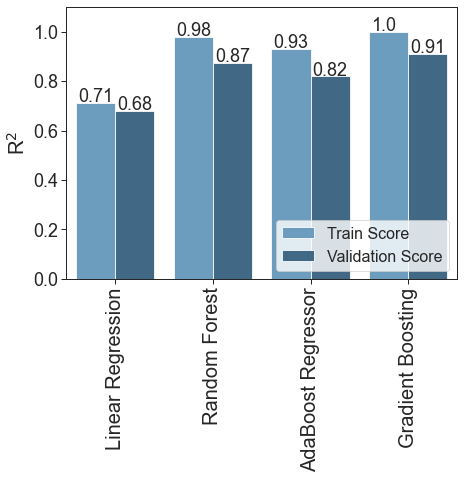

In [259]:
# Plot the base scores
fig, ax = plt.subplots(figsize=(7,5))

sns.barplot(x = 'Models', y = 'Value', data = model_compare, hue = 'Score', palette = 'Blues_d', ax = ax)

plt.xticks(fontsize=20, rotation=90);
plt.xlabel("", fontsize=20);
plt.yticks(fontsize=18);
plt.ylabel(r"R$^2$", fontsize=20);

plt.ylim([0, 1.1])
plt.yticks(np.arange(0, 1.2, 0.2))

plt.legend(prop={"size":16}, loc = 4)

x_offset = 0.00
y_offset = 0.00

for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() + 0.02, p.get_height() * 1.005), fontsize = 18)

### Building an evaluation function that calculates different error metrics
Adapted from: https://github.com/mrdbourke.

In [231]:
# Create function to evaluate our model
def show_scores(model, X_train, X_test, y_train, y_test):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_test)
    scores = {"Train MSE": mean_squared_error(y_train, train_preds, squared=True),
              "Test MSE": mean_squared_error(y_test, val_preds, squared=True),
              "Train RMSE": mean_squared_error(y_train, train_preds, squared=False),
              "Test RMSE": mean_squared_error(y_test, val_preds, squared=False),
              "Train R^2": model.score(X_train, y_train),
              "Test R^2": model.score(X_test, y_test)}
    return scores

### Optimizing the Random Forest Regressor
Here, we will optimize the hyperparameters for the Random Forest Regressor model, as well as explore the evolution of different metrics.

#### Number of estimators
Here, we will plot the evolution of the RMSE and R$^2$ as a function of the *n_estimators*, *min_sample_split* and *max_depth parameters*. 

In [232]:
### Iterate over the number of estimators in the Random Forest

# Create a list to store the metrics
index_estimators = []
r2_estimators = []
rmse_estimators = []

cv = KFold(n_splits = 5) # n_splits = 5 means 80:20 training:validation

# Iterate over a hyperparameter
for i in np.arange(0, 500, 10):
    test_model_rf_NOD = RandomForestRegressor(n_estimators = i,
                                    min_samples_leaf = 1,
                                    min_samples_split = 3,
                                    max_features = 'auto',
                                    max_depth = 10,
                                    max_samples = None,
                                    random_state = 42)
    
    val_scores_r2 = cross_val_score(test_model_rf_NOD, X_train_NOD, y_train_NOD, 
                                    cv = cv, scoring = 'r2')
    val_scores_rmse = cross_val_score(test_model_rf_NOD, X_train_NOD, y_train_NOD, 
                                      cv = cv, scoring = 'neg_root_mean_squared_error')

    # Store the scores in a list
    index_estimators.append(i)
    r2_estimators.append(val_scores_r2.mean())
    rmse_estimators.append(val_scores_rmse.mean())

In [233]:
# Create a dataframe with the number of estimators
rf_estimators_NOD = pd.DataFrame(
    {
        'Nº of Estimators': index_estimators,
        'R2 validation': r2_estimators,
        'RMSE validation': rmse_estimators
    }
)

# Convert negative RMSE to positive
rf_estimators_NOD['RMSE validation'] = rf_estimators_NOD['RMSE validation'].abs()

In [234]:
### Iterate over the min_sample_split in the Random Forest

# Create a list to store the metrics
index_min_sample = []
rmse_min_sample = []
r2_min_sample = []

# Iterate over a hyperparameter
for i in np.arange(2, 11, 1):
    test_model_rf_NOD = RandomForestRegressor(n_estimators = 30,
                                    min_samples_leaf = 1,
                                    min_samples_split = i,
                                    max_features = 'auto',
                                    max_depth = 10,
                                    max_samples = None,
                                    random_state = 42)
    
    val_scores_r2_min_sample = cross_val_score(test_model_rf_NOD, X_train_NOD, y_train_NOD, 
                                               cv = cv, scoring = 'r2')
    val_scores_rmse_min_sample = cross_val_score(test_model_rf_NOD, X_train_NOD, y_train_NOD, 
                                                 cv = cv, scoring = 'neg_root_mean_squared_error')
    
    # Store the scores in a list
    index_min_sample.append(i)
    r2_min_sample.append(val_scores_r2_min_sample.mean())
    rmse_min_sample.append(val_scores_rmse_min_sample.mean())

In [235]:
# Create a dataframe with the min_sample_split
rf_split_NOD = pd.DataFrame(
    {
        'Minimum Sample Split': index_min_sample,
        'R2 validation': r2_min_sample,
        'RMSE validation': rmse_min_sample
    }
)

# Convert negative RMSE to positive
rf_split_NOD['RMSE validation'] = rf_split_NOD['RMSE validation'].abs()

In [236]:
### Iterate over the max_depth in the Random Forest

# Create a list to store the metrics
index_depth = []
rmse_depth = []
r2_depth = []

# Iterate over a hyperparameter
for i in np.arange(2, 20, 1):
    test_model_rf_NOD = RandomForestRegressor(n_estimators = 30,
                                    min_samples_leaf = 1,
                                    min_samples_split = 3,
                                    max_features = 'auto',
                                    max_depth = i,
                                    max_samples = None,
                                    random_state = 42)
    val_scores_r2_depth = cross_val_score(test_model_rf_NOD, X_train_NOD, y_train_NOD, 
                                          cv = cv, scoring = 'r2')
    val_scores_rmse_depth = cross_val_score(test_model_rf_NOD, X_train_NOD, y_train_NOD, 
                                            cv = cv, scoring = 'neg_root_mean_squared_error')
    
    # Store the scores in a list
    index_depth.append(i)
    r2_depth.append(val_scores_r2_depth.mean())
    rmse_depth.append(val_scores_rmse_depth.mean())

In [237]:
# Create a dataframe with the max_depth
rf_depth_NOD = pd.DataFrame(
    {
        'Maximum Depth': index_depth,
        'R2 validation': r2_depth,
        'RMSE validation': rmse_depth
    }
)

# Convert negative RMSE to positive
rf_depth_NOD['RMSE validation'] = rf_depth_NOD['RMSE validation'].abs()

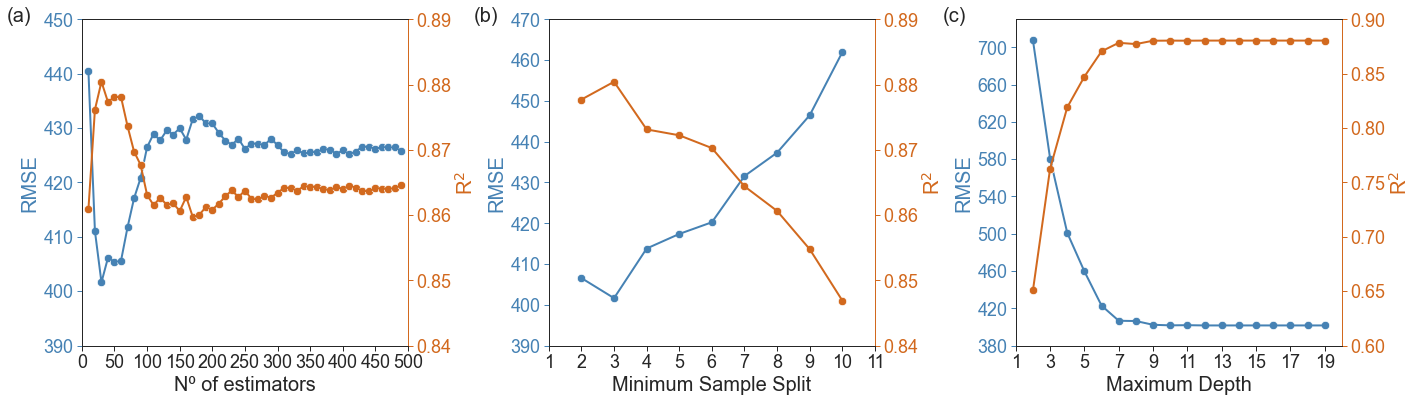

In [238]:
# Define the grid
fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize=(14,4))

# Plot the different metrics as a function of the number of estimators
g1_rmse_scatter = sns.scatterplot(x = 'Nº of Estimators', y = 'RMSE validation', s=70, 
                                  color = 'steelblue', data = rf_estimators_NOD, ax = axs[0])
g1_rmse_line = sns.lineplot(x = 'Nº of Estimators', y = 'RMSE validation', linewidth = 2, 
                            color = 'steelblue', data = rf_estimators_NOD, ax = axs[0])

# Twin object for two different y-axis on the sample plot axs[0]
ax1_twin=axs[0].twinx()

g1_r2_scatter = sns.scatterplot(x = 'Nº of Estimators', y = 'R2 validation', s=70, 
                                color = 'chocolate', data = rf_estimators_NOD)
g1_r2_line = sns.lineplot(x = 'Nº of Estimators', y = 'R2 validation', linewidth = 2, 
                          color = 'chocolate', data = rf_estimators_NOD)

# Plot the different metrics as a function of the minimum sample split
g2_rmse_scatter = sns.scatterplot(x = 'Minimum Sample Split', y = 'RMSE validation', s=70, 
                                  color = 'steelblue', data = rf_split_NOD, ax = axs[1])
g2_rmse_line = sns.lineplot(x = 'Minimum Sample Split', y = 'RMSE validation', linewidth = 2, 
                            color = 'steelblue', data = rf_split_NOD, ax = axs[1])

# Twin object for two different y-axis on the sample plot axs[1]
ax2_twin=axs[1].twinx()

g2_r2_scatter = sns.scatterplot(x = 'Minimum Sample Split', y = 'R2 validation', s=70, 
                                color = 'chocolate', data = rf_split_NOD, ax = ax2_twin)
g2_r2_line = sns.lineplot(x = 'Minimum Sample Split', y = 'R2 validation', linewidth = 2, 
                          color = 'chocolate', data = rf_split_NOD, ax = ax2_twin)

# Plot the different metrics as a function of the maximum depth
g3_rmse_scatter = sns.scatterplot(x = 'Maximum Depth', y = 'RMSE validation', s=70, 
                                  color = 'steelblue', data = rf_depth_NOD, ax = axs[2])
g3_rmse_line = sns.lineplot(x = 'Maximum Depth', y = 'RMSE validation', linewidth = 2, 
                            color = 'steelblue', data = rf_depth_NOD, ax = axs[2])

# Twin object for two different y-axis on the sample plot axs[2]
ax3_twin=axs[2].twinx()

g3_r2_scatter = sns.scatterplot(x = 'Maximum Depth', y = 'R2 validation', s=70, 
                                color = 'chocolate', data = rf_depth_NOD, ax = ax3_twin)
g3_r2_line = sns.lineplot(x = 'Maximum Depth', y = 'R2 validation', linewidth = 2, 
                          color = 'chocolate', data = rf_depth_NOD, ax = ax3_twin)

### Customize the axs[0] plot

# Customize the RMSE plot
axs[0].set_xlabel('Nº of estimators', fontsize = 20)
axs[0].set_ylabel('RMSE', fontsize = 20, color = 'steelblue')
axs[0].tick_params(labelsize = 18)
axs[0].set_xlim([0, 500])
axs[0].set_ylim([390, 450])
axs[0].set_xticks(np.arange(0, 510, 50))
axs[0].set_yticks(np.arange(390, 460, 10))
axs[0].spines['left'].set_color('steelblue')
axs[0].tick_params(axis='y', colors='steelblue')

# Customize the R2 plot
ax1_twin.set_ylabel(r'R$^2$', fontsize = 20, color = 'chocolate')
ax1_twin.tick_params(axis = 'y', labelsize = 18)
ax1_twin.set_ylim([0.84, 0.88])
ax1_twin.set_yticks(np.arange(0.84, 0.89, 0.01))
ax1_twin.spines['right'].set_color('chocolate')
ax1_twin.tick_params(axis='y', colors='chocolate')

### Customize the axs[1] plot

# Customize the RMSE plot
axs[1].set_xlabel('Minimum Sample Split', fontsize = 20)
axs[1].set_ylabel('RMSE', fontsize = 20, color = 'steelblue')
axs[1].tick_params(labelsize = 18)
axs[1].set_xlim([1, 11])
axs[1].set_ylim([390, 470])
axs[1].set_xticks(np.arange(1, 12, 1))
axs[1].set_yticks(np.arange(390, 480, 10))
axs[1].spines['left'].set_color('steelblue')
axs[1].tick_params(axis='y', colors='steelblue')

# Customize the R2 plot
ax2_twin.set_ylabel(r'R$^2$', fontsize = 20, color = 'chocolate')
ax2_twin.tick_params(axis = 'y', labelsize = 18, color = 'chocolate')
ax2_twin.set_ylim([0.84, 0.89])
ax2_twin.set_yticks(np.arange(0.84, 0.89, 0.01))
ax2_twin.spines['right'].set_color('chocolate')
ax2_twin.tick_params(axis='y', colors='chocolate')

### Customize the axs[2] plot

# Customize the RMSE plot
axs[2].set_xlabel('Maximum Depth', fontsize = 20)
axs[2].set_ylabel('RMSE', fontsize = 20, color = 'steelblue')
axs[2].tick_params(labelsize = 18)
axs[2].set_xlim([1, 20])
axs[2].set_ylim([380, 730])
axs[2].set_xticks(np.arange(1, 21, 2))
axs[2].set_yticks(np.arange(380, 730, 40))
axs[2].spines['left'].set_color('steelblue')
axs[2].tick_params(axis='y', colors='steelblue')

# Customize the R2 plot
ax3_twin.set_ylabel(r'R$^2$', fontsize = 20, color = 'chocolate')
ax3_twin.tick_params(axis = 'y', labelsize = 18, color = 'chocolate')
ax3_twin.set_ylim([0.60, 0.90])
ax3_twin.set_yticks(np.arange(0.60, 0.90, 0.05))
ax3_twin.spines['right'].set_color('chocolate')
ax3_twin.tick_params(axis='y', colors='chocolate')

# Figure labels
fig.text(-0.003, 1.35, '(a)', va='center', rotation='horizontal', fontsize = 20)
fig.text(0.46, 1.35, '(b)', va='center', rotation='horizontal', fontsize = 20)
fig.text(0.925, 1.35, '(c)', va='center', rotation='horizontal', fontsize = 20)

# set the spacing between subplots 
plt.subplots_adjust(left=0.0, 
                    bottom=0.0,  
                    right=0.9,  
                    top=0.9,  
                    wspace=2.5,  
                    hspace=0.5)

plt.tight_layout(rect=(0, 0, 1.4, 1.4));

### Train a model with the best parameters
The Random Forest will be trained on the best parameters to calculate the values of the evaluation metrics. Then, it will be fit to the whole train set and evaluated to a final test set.

In [239]:
%%time
cv = KFold(n_splits = 5) # n_splits = 5 means 80:20 training:validation

# Most ideal hyperparameters
ideal_model_rf_NOD = RandomForestRegressor(n_estimators = 30,
                                    min_samples_leaf = 1,
                                    min_samples_split = 3,
                                    max_features = 'auto',
                                    max_depth = 10,
                                    max_samples = None,
                                    random_state = 42)

val_scores_r2 = cross_validate(ideal_model_rf_NOD, X_train_NOD, y_train_NOD, 
                               cv = cv, scoring = 'r2', return_train_score = True)
val_scores_rmse = cross_validate(ideal_model_rf_NOD, X_train_NOD, y_train_NOD, 
                                 cv = cv, scoring = 'neg_root_mean_squared_error', return_train_score = True)

# Scores
val_scores_r2
val_scores_rmse

Wall time: 498 ms


{'fit_time': array([0.03793144, 0.04189229, 0.03889656, 0.03937387, 0.03892422]),
 'score_time': array([0.0049541 , 0.00400281, 0.00498676, 0.00498676, 0.0039897 ]),
 'test_score': array([-278.52432687, -283.09549218, -586.58030557, -341.14274184,
        -518.74757039]),
 'train_score': array([-163.1935159 , -184.62277528, -157.98131451, -213.5271023 ,
        -199.60647827])}

#### Calculate mean value of R2

In [240]:
# Train score
val_scores_r2['train_score'].mean()

0.9770307779988097

In [241]:
# Validation score
val_scores_r2['test_score'].mean()

0.8804316065507465

#### Calculate mean value of RMSE

In [242]:
# Train score
abs(val_scores_rmse['train_score'].mean())

183.78623725244955

In [243]:
# Validation score
abs(val_scores_rmse['test_score'].mean())

401.6180873699609

#### Fit the model on the whole training set and calculate the scores for the test set

In [244]:
# Fit the ideal model on the whole training set
ideal_model_rf_NOD.fit(X_train_NOD, y_train_NOD)

# Calculate the scores for the test set
ideal_scores_NOD = show_scores(ideal_model_rf_NOD, X_train_NOD, X_test_NOD, y_train_NOD, y_test_NOD)
ideal_scores_NOD

{'Train MSE': 30959.503225593493,
 'Test MSE': 83767.58209395559,
 'Train RMSE': 175.95312792216424,
 'Test RMSE': 289.4262982072562,
 'Train R^2': 0.9792255963633723,
 'Test R^2': 0.9424093024163831}

The scores for the train set shown here correspond to the ones for the whole set without cross-validation.

#### Calculation of the variable importance
We will plot the variable importance which lists the variables of the model by order of importance in descending order. The top variables contribute more to the model than the bottom ones and thus have high predictive power. The SHAP library is being used to calculate it, and it is based on the mean absolute value of the SHAP values for each feature.

Check https://github.com/slundberg/shap for details on the implementation of the SHAP library.

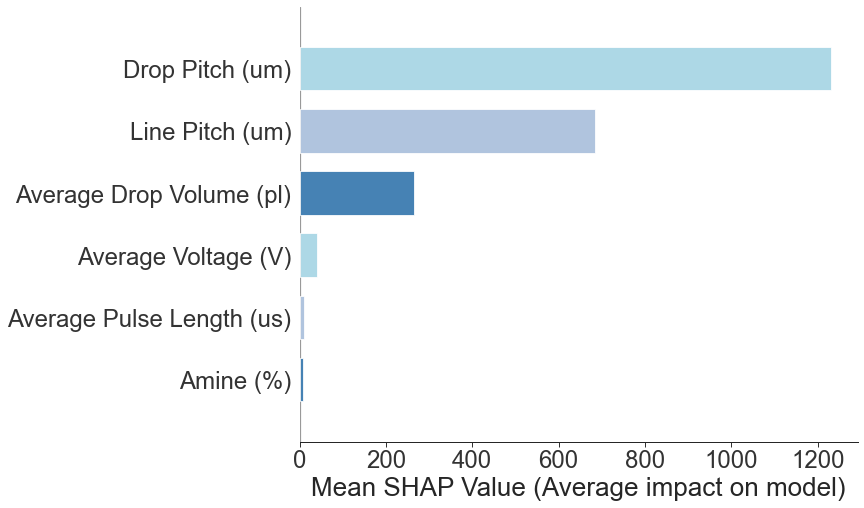

In [245]:
# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(ideal_model_rf_NOD, X_train_NOD)
shap_values = explainer.shap_values(X_test_NOD)
shap.summary_plot(shap_values, X_test_NOD, color = ["steelblue", "lightsteelblue", "lightblue"], 
                  plot_type="bar", show=False)

# Customize SHAP plot
fig = plt.gcf()
fig.set_figheight(8)
fig.set_figwidth(10)
ax = plt.gca()
ax.set_xlabel(r'Mean SHAP Value (Average impact on model)', fontsize=26)
ax.tick_params(labelsize=24)

#ax.set_xlabel(r'durchschnittliche SHAP Werte $\vert\sigma_{ij}\vert$', fontsize=16)
#ax.set_ylabel('Inputparameter', fontsize=16)
#ylabels = string_latexer([tick.get_text() for tick in ax.get_yticklabels()])
#ax.set_yticklabels(ylabels)
#leg = ax.legend()

plt.show()

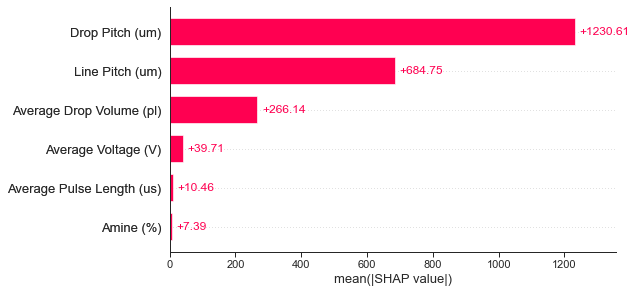

In [246]:
shap.plots.bar(explainer(X_test_NOD))

### Model of the variable **Nº of drops** by dropping unimportant features
We will remove the previous unimportant variables from the model to determine how the accuracy and RMSE vary.

In [247]:
# Drop columns from train and test sets
X_train_NOD_reduced = X_train_NOD.drop(labels=[
                                 'Average Voltage (V)', 'Average Pulse Length (us)', 'Amine (%)'
                                ], axis=1, inplace=False)

X_test_NOD_reduced = X_test_NOD.drop(labels=[
                                 'Average Voltage (V)', 'Average Pulse Length (us)', 'Amine (%)'
                                ], axis=1, inplace=False)

#pd.set_option('display.max_rows', None)

# Check the dataset
#X_train_NOD_reduced
#X_test_NOD_reduced

#### Train a new model with the reduced dataset
We will train a RF model with the reduced dataset

In [248]:
%%time

# Most ideal hyperparameters
ideal_model_rf_NOD_reduced = RandomForestRegressor(n_estimators = 30,
                                    min_samples_leaf = 1,
                                    min_samples_split = 3,
                                    max_features = 'auto',
                                    max_depth = 10,
                                    max_samples = None,
                                    random_state = 42)
ideal_model_rf_NOD_reduced.fit(X_train_NOD_reduced, y_train_NOD)

Wall time: 38.9 ms


RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=30,
                      random_state=42)

In [249]:
scores_NOD_reduced = show_scores(ideal_model_rf_NOD_reduced, X_train_NOD_reduced, 
                                 X_test_NOD_reduced, y_train_NOD, y_test_NOD)
scores_NOD_reduced

{'Train MSE': 27870.414093975374,
 'Test MSE': 72331.74269158205,
 'Train RMSE': 166.9443443006542,
 'Test RMSE': 268.9456128877771,
 'Train R^2': 0.9812984327400459,
 'Test R^2': 0.9502715082026049}

#### Plot model accuracy and RMSE for full dataset vs reduced dataset

In [250]:
ideal_scores_NOD

{'Train MSE': 30959.503225593493,
 'Test MSE': 83767.58209395559,
 'Train RMSE': 175.95312792216424,
 'Test RMSE': 289.4262982072562,
 'Train R^2': 0.9792255963633723,
 'Test R^2': 0.9424093024163831}

In [251]:
# Create dataframe with scores from full dataset
ideal_scores_NOD_df = pd.DataFrame.from_dict(ideal_scores_NOD, orient = 'index', columns = ['Value'])
ideal_scores_NOD_df.reset_index(drop = False, inplace = True)
ideal_scores_NOD_df = ideal_scores_NOD_df.rename(columns = {'index':'Metric'})
ideal_scores_NOD_df.drop([ideal_scores_NOD_df.index[0], ideal_scores_NOD_df.index[1]], inplace = True)
ideal_scores_NOD_df.reset_index(drop = True, inplace = True)

In [252]:
ideal_scores_NOD_df

,Metric,Value
0,Train RMSE,175.953128
1,Test RMSE,289.426298
2,Train R^2,0.979226
3,Test R^2,0.942409


In [253]:
# Create dataframe with scores from reduced dataset
reduced_scores_NOD_df = pd.DataFrame.from_dict(scores_NOD_reduced, orient = 'index', columns = ['Value'])
reduced_scores_NOD_df.reset_index(drop = False, inplace = True)
reduced_scores_NOD_df = reduced_scores_NOD_df.rename(columns = {'index':'Metric'})
reduced_scores_NOD_df.drop([reduced_scores_NOD_df.index[0], reduced_scores_NOD_df.index[1]], inplace = True)
reduced_scores_NOD_df.reset_index(drop = True, inplace = True)

In [254]:
reduced_scores_NOD_df

,Metric,Value
0,Train RMSE,166.944344
1,Test RMSE,268.945613
2,Train R^2,0.981298
3,Test R^2,0.950272


In [255]:
# Concatenate dataframes
concat_scores_NOD = pd.concat([ideal_scores_NOD_df, reduced_scores_NOD_df])
concat_scores_NOD.reset_index(drop=True, inplace = True)

# Separate dataframe in two and add column based on Full or Reduced dataset
concat_scores_NOD_rmse = concat_scores_NOD.loc[concat_scores_NOD['Metric'].isin(['Train RMSE', 'Test RMSE'])]
concat_scores_NOD_rmse.reset_index(drop=True, inplace = True)
concat_scores_NOD_rmse['Dataset'] = ['Full', 'Full', 'Reduced', 'Reduced']

concat_scores_NOD_r2 = concat_scores_NOD.loc[concat_scores_NOD['Metric'].isin(['Train R^2', 'Test R^2'])]
concat_scores_NOD_r2.reset_index(drop=True, inplace = True)
concat_scores_NOD_r2['Dataset'] = ['Full', 'Full', 'Reduced', 'Reduced']

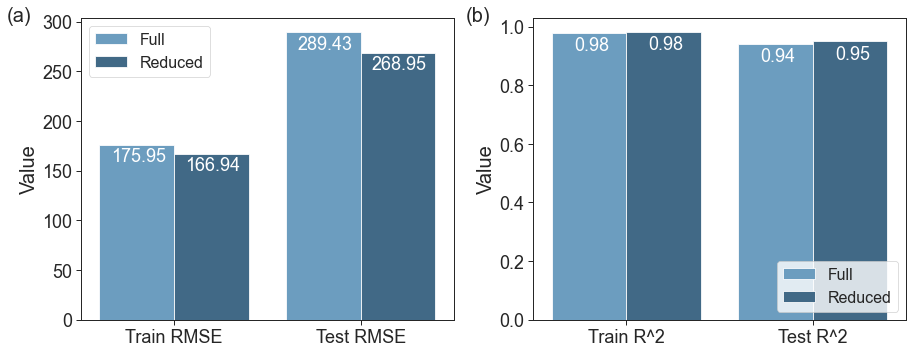

In [256]:
# Plot the RMSE and R2 for both datasets
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(9,3.5))

g1 = sns.barplot(x = 'Metric', y = 'Value', palette = 'Blues_d', hue = 'Dataset', 
                 data = concat_scores_NOD_rmse, ax = axes[0])
g2 = sns.barplot(x = 'Metric', y = 'Value', palette = 'Blues_d', hue = 'Dataset', 
                 data = concat_scores_NOD_r2, ax = axes[1])

### Customize the axes[0] plot
# Customize the RMSE plot
axes[0].set_xlabel('', fontsize = 20)
axes[0].set_ylabel('Value', fontsize = 20)
axes[0].tick_params(labelsize = 18)
axes[0].legend(prop={"size":16}, loc = 0)

### Customize the axes[1] plot
# Customize the R2 plot
axes[1].set_xlabel('', fontsize = 20)
axes[1].set_ylabel('Value', fontsize = 20)
axes[1].tick_params(labelsize = 18)
axes[1].legend(prop={"size":16}, loc = 4)

for p in g1.patches:
    g1.annotate(str(round(p.get_height(),2)), (p.get_x() + 0.06, p.get_height() - 17), 
                fontsize = 18, color = 'white')

for p in g2.patches:
    g2.annotate(str(round(p.get_height(),2)), (p.get_x() + 0.12, p.get_height() - 0.06), 
                fontsize = 18, color = 'white')

# Figure labels
fig.text(-0.003, 1.35, '(a)', va='center', rotation='horizontal', fontsize = 20)
fig.text(0.705, 1.35, '(b)', va='center', rotation='horizontal', fontsize = 20)

x_offset = 0.00
y_offset = 0.00

# set the spacing between subplots 
plt.subplots_adjust(left=0.0, 
                    bottom=0.0,  
                    right=0.9,  
                    top=0.9,  
                    wspace=1,  
                    hspace=0.5)

plt.tight_layout(rect=(0, 0, 1.4, 1.4));